# Neural FrameWork

* Pablo Alonso López.
* Marcos Cedenilla Bonet.

## Activations

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Sigmoid():
    
    def function(x):
        return 1 / (1 + np.exp(-x))
    
    def derivative(x):
        return Sigmoid.function(x) * (1 - Sigmoid.function(x))
    
    def __str__(self):
        return "Sigmoid"
    

class Linear():
    
    def function(x):
        return x

    def derivative(x):
        return np.ones(x.shape)
    
    def __str__(self):
        return "Linear"
    
class Tanh():
    
    def function(x):
        return np.tanh(x)
    
    def derivative(x):
        return 1 - np.square(Tanh.tanh(x))
    
    def __str__(self):
        return "Tanh"
    
    
class ReLu():
    
    def function(x):
        return np.where(x>0, x, np.zeros(x.shape))
    
    def derivative(x):
        return np.where(x>0, np.ones(x.shape), np.zeros(x.shape))
    
    def __str__(self):
        return "ReLu"


## Layer

In [2]:
class Layer():
    
    def __init__(self, n_neurons, input_shape, activation = "sigmoid"):
        self.weights = np.random.rand(input_shape, n_neurons) * 2 -1
        self.bias = np.random.rand(n_neurons).reshape(1,n_neurons) * 2 -1
        self.n_neurons = n_neurons
        
        if activation.lower() == "relu":
            self.activation = ReLu
        elif activation.lower() == "linear":
            self.activation = Linear 
        elif activation.lower() == "tanh":
            self.activation = Tanh         
        else:
            self.activation = Sigmoid
            
    def output(self, x):
        return self.activation.function(x@self.weights + self.bias)
    
    def z(self, x):
        return x@self.weights + self.bias
            

## MLP

In [3]:
class MLP_compiled():
    def __init__(self, topology, layers, activation, f_input_shape, learning_rate):
        self.__layers = layers
        self.__activation = activation
        self.__topology = topology
        self.__f_input_shape = f_input_shape
        self.__learning_rate = learning_rate
        
    def layers(self):
        return self.__layers
        
    
    def summary(self):
        print("--------Multi-Layer Perceptron--------")
        print("--------------------------------------")
        
        layers = list(self.__topology.keys())
        neurons = list(self.__topology.values())
        layers[-1] = "Output layer"
        aux = neurons[0]
        params = self.__f_input_shape * aux + aux
        for i in range(len(layers)):
            print(layers[i] + "      " + str(neurons[i]) + " Neurons; Activation: " + self.__activation[i])
            
        for i in neurons[1:]:
            params +=  aux*i + i
            aux = i
            
        print("--------------------------------------")
        print("--------------------------------------")
            
        print(str(params) + " Parameters")
        
    def loss(self, y_true, y_pred):
        return np.mean(np.square(y_true - y_pred))
        
    def accuracy(self, y_true: np.array, y_pred: np.array):
        aux = []
        if y_pred.shape[1] == 1:
            aux = np.round(y_pred)
        else:
            for i in y_pred:
                temp = np.zeros(len(i))
                temp[np.argmax(i)] = 1
                aux.append(temp)
        return np.mean(np.array(aux) == y_true)
        
    
    def predict(self, X):
        aux = []
        for i in X:
            aux.append(self.forward(i))
        return np.array(aux).reshape(X.shape[0], self.__layers[-1].n_neurons)
        
        
    def forward(self, x): 
        self.__outputs = []
        self.__zs = []
        x = x.reshape(1,x.size)
        for i in self.__layers:
            self.__outputs.append(x)
            self.__zs.append(i.z(x))
            x = i.output(x)
        return x
    
    def backpropagate(self, s, y): 
        
        aux = list(range(len(self.__layers)))
        aux.reverse()
        i = aux[0]

        # Last layer
        
        delta = (y-s)*self.__layers[i].activation.derivative(self.__zs[i])

        if len(delta.shape) == 1:
            delta = delta.reshape(1,delta.size)
        w = self.__layers[i].weights

        self.__layers[i].weights += self.__learning_rate*(self.__outputs[i].T @ delta)

        self.__layers[i].bias += self.__learning_rate*delta

        
        # Hidden layers
        
        for i in aux[1:]:
            r = w@delta.T

            delta = r.T * self.__layers[i].activation.derivative(self.__zs[i])

            w = self.__layers[i].weights

            self.__layers[i].weights += self.__learning_rate*(self.__outputs[i].T @ delta)

            self.__layers[i].bias += self.__learning_rate*delta
            

            
        
    def train(self, X, Y, epochs, validation_data = False, metrics = False, verbose = 0): 
        
        loss_hist = []
        
        if metrics!= False:
            metrics_hist = []

        for i in range(epochs): 
            if verbose:
                print("Epoch: " + str(i+1))

            for x in range(len(X)):
                s = self.forward(X[x])

                self.backpropagate(s,Y[x])
            
           
            yt_pred = self.predict(X)
            loss = [self.loss(Y,yt_pred)]
            
            if metrics!= False:
                accuracy = [self.accuracy(Y,yt_pred)]
                    
                        
            if validation_data != False:
                y_pred = self.predict(validation_data[0])
                val_loss = self.loss(validation_data[1],y_pred)
                loss.append(val_loss)
                    
                if metrics!= False:
                    val_accuracy = self.accuracy(validation_data[1],y_pred)
                    accuracy.append(val_accuracy)
                            
                            
                            
            if verbose:
                print("Train Loss: ", loss[0])
                if metrics!= False:
                    if metrics.lower() == "accuracy":
                        print("Train accuracy: ", accuracy[0]) 
                if validation_data != False:
                    print("Validation Loss: ", val_loss)
                    if metrics!= False:
                        print("Validation accuracy: ", val_accuracy) 
            loss_hist.append(loss)
            metrics_hist.append(accuracy)
                            
        return loss_hist, metrics_hist
                
                    

            
            
            
        
    

In [4]:
           
class MLP():
    
    def __init__(self, f_input_shape):
        self.__topology = dict()
        self.__activation = list()
        self.__layers = list()
        self.__f_input_shape = f_input_shape
        
    def add_layer(self, n_neurons, activation = "sigmoid"): # Function to add layers; it is not necessary to specify the input shape in any case. 
                                                            # The shape of the first input will be specified in the network constructor, and the rest will be calculated based 
                                                            # on the shape of the previous layer's output. 
        
        if len(self.__layers) == 0:
            self.__layers.append(Layer(n_neurons, self.__f_input_shape, activation))
            self.__topology["Input Layer"] = n_neurons
            self.__activation.append(str(self.__layers[-1].activation()))
        else:
            self.__layers.append(Layer(n_neurons, self.__layers[-1].n_neurons, activation))
            self.__topology["Layer " + str(len(self.__layers)-1)] = n_neurons
            self.__activation.append(str(self.__layers[-1].activation()))
            
    def compile(self, learning_rate):
        return MLP_compiled(self.__topology, self.__layers, self.__activation, self.__f_input_shape, learning_rate)

        
        

## Non Linear

In [5]:
def one_hot (d):
    num_classes = len(set(d))
    rows = d.shape[0]
    labels = np.zeros((rows, num_classes), dtype='float32')
    labels[np.arange(rows),d.T] = 1
    return labels


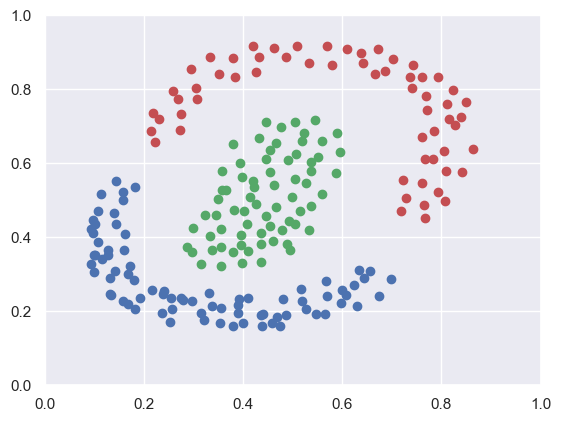

In [106]:

X = np.loadtxt('samples/data_3classes_nonlinear_2D.txt')

d = X[:,-1].astype('int')
X = X[:,:-1]

plt.figure()
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot(X[d==0,0],X[d==0,1], 'ro')
plt.plot(X[d==1,0],X[d==1,1], 'go')
plt.plot(X[d==2,0],X[d==2,1], 'bo')
plt.show()

no = len(set(d))
ni = X.shape[1]

d = one_hot(d)


In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,d,test_size=0.2, random_state=14)

In [73]:
model = MLP(2)

model.add_layer(3, "sigmoid")
model.add_layer(3,"Sigmoid")

model = model.compile(0.1)
model.summary()

--------Multi-Layer Perceptron--------
--------------------------------------
Input Layer      3 Neurons; Activation: Sigmoid
Output layer      3 Neurons; Activation: Sigmoid
--------------------------------------
--------------------------------------
21 Parameters


In [74]:
loss, accuracy = model.train(X_train,y_train, validation_data=[X_test, y_test], metrics=True, epochs = 2500)

[]

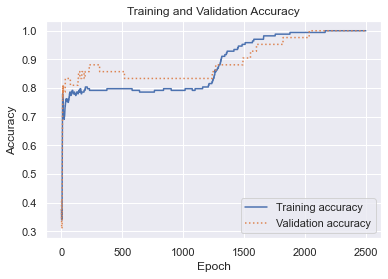

In [76]:
import seaborn as sns

accuracy = np.array(accuracy)

accuracy = accuracy.T
sns.set()
 
epochs = range(1, len(accuracy[0]) + 1)
 
plt.plot(epochs, accuracy[0], '-', label='Training accuracy')
plt.plot(epochs, accuracy[1], ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Iris

In [175]:

X = np.loadtxt('samples/iris.csv', dtype = 'float64', usecols = [0,1,2,3])
L = np.loadtxt('samples/iris.csv', dtype = str, usecols = [4]) 

d = []
options = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
for e in L:
    d.append(options.index(e))

d = np.array(d)
X = np.array(X)

d = one_hot(d)

ni = X.shape[1]
X_train, X_test, y_train, y_test = train_test_split(X,d,test_size=0.3, random_state=33)

In [176]:
model = MLP(ni)

model.add_layer(3, "sigmoid")
model.add_layer(3,"Sigmoid")

model = model.compile(0.05)
model.summary()

--------Multi-Layer Perceptron--------
--------------------------------------
Input Layer      3 Neurons; Activation: Sigmoid
Output layer      3 Neurons; Activation: Sigmoid
--------------------------------------
--------------------------------------
27 Parameters


In [177]:
loss, accuracy = model.train(X_train,y_train, validation_data=[X_test, y_test], metrics=True, epochs = 100)

[]

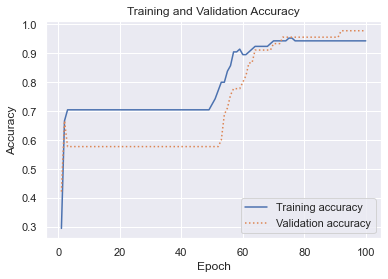

In [178]:

accuracy = np.array(accuracy)

accuracy = accuracy.T
sns.set()
 
epochs = range(1, len(accuracy[0]) + 1)
 
plt.plot(epochs, accuracy[0], '-', label='Training accuracy')
plt.plot(epochs, accuracy[1], ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [179]:
print(accuracy[1,-1])

0.9777777777777777


## Morosos

In [6]:
train = np.loadtxt('samples/morosos-ent.txt', dtype = 'float64')
test = np.loadtxt('samples/morosos-tst.txt', dtype = 'float64') 

X_train = train[:,:-1]
X_test = test[:,:-1]
y_train = train[:,-1].reshape(len(train),1)
y_test = test[:,-1].reshape(len(test),1)

ni = X_train.shape[1]

In [59]:
model = MLP(ni)


model.add_layer(1,"Sigmoid")

model = model.compile(0.1)
model.summary()

loss, accuracy = model.train(X_train,y_train, validation_data=[X_test, y_test], metrics=True, epochs = 300)

--------Multi-Layer Perceptron--------
--------------------------------------
Output layer      1 Neurons; Activation: Sigmoid
--------------------------------------
--------------------------------------
10 Parameters


[]

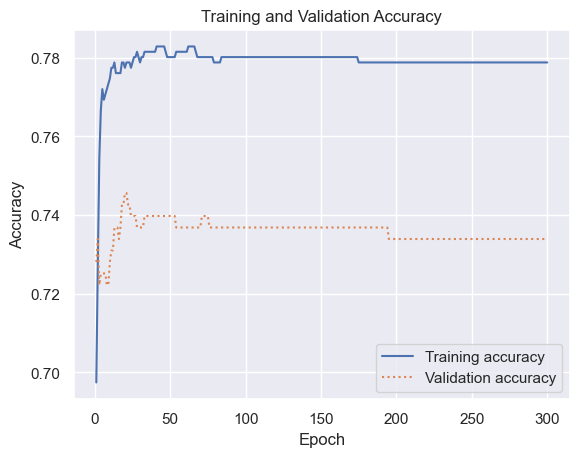

In [60]:
import seaborn  as sns

accuracy = np.array(accuracy)

accuracy = accuracy.T
sns.set()
 
epochs = range(1, len(accuracy[0]) + 1)
 
plt.plot(epochs, accuracy[0], '-', label='Training accuracy')
plt.plot(epochs, accuracy[1], ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [ ]:
model = MLP(ni)

model.add_layer(10,"Sigmoid")
model.add_layer(1,"Sigmoid")

model = model.compile(0.1)
model.summary()

loss, accuracy = model.train(X_train,y_train, validation_data=[X_test, y_test], metrics=True, epochs = 2000)


accuracy = np.array(accuracy)

accuracy = accuracy.T


[]

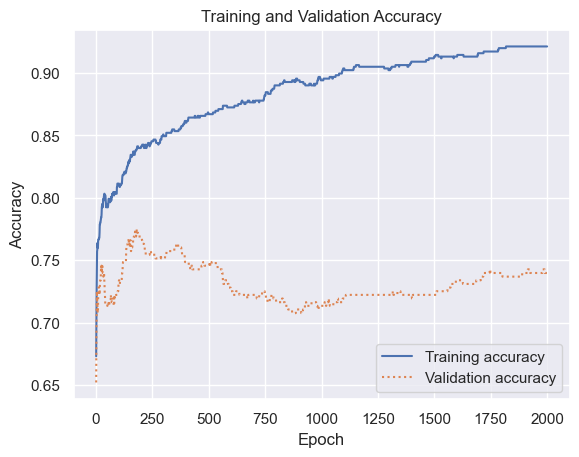

In [8]:
import seaborn as sns
sns.set()
 
epochs = range(1, len(accuracy[0]) + 1)
 
plt.plot(epochs, accuracy[0], '-', label='Training accuracy')
plt.plot(epochs, accuracy[1], ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

## Circle

In [152]:


train = np.loadtxt('samples/circulo.txt', dtype = 'float64')


X_train = train[:,:2]

y_train = train[:,2:].reshape(len(train),3)

ni = X_train.shape[1]

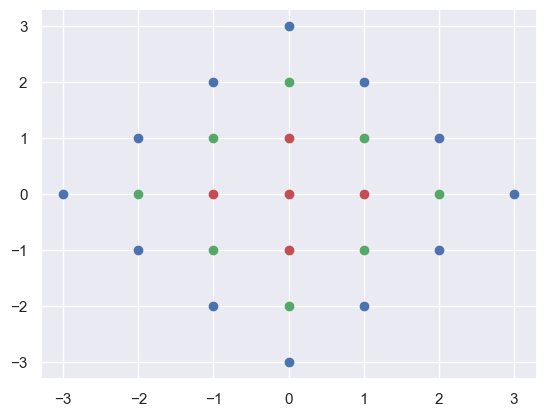

In [180]:

X = X_train

d = np.argmax(y_train, axis=1)

plt.figure()

plt.plot(X[d==0,0],X[d==0,1], 'ro')
plt.plot(X[d==1,0],X[d==1,1], 'go')
plt.plot(X[d==2,0],X[d==2,1], 'bo')
plt.show()



In [178]:
model = MLP(ni)

model.add_layer(7,"Sigmoid")
model.add_layer(3,"Sigmoid")

model = model.compile(0.1)
model.summary()

loss, accuracy = model.train(X_train,y_train, metrics=True, epochs = 2000)

--------Multi-Layer Perceptron--------
--------------------------------------
Input Layer      7 Neurons; Activation: Sigmoid
Output layer      3 Neurons; Activation: Sigmoid
--------------------------------------
--------------------------------------
45 Parameters


[]

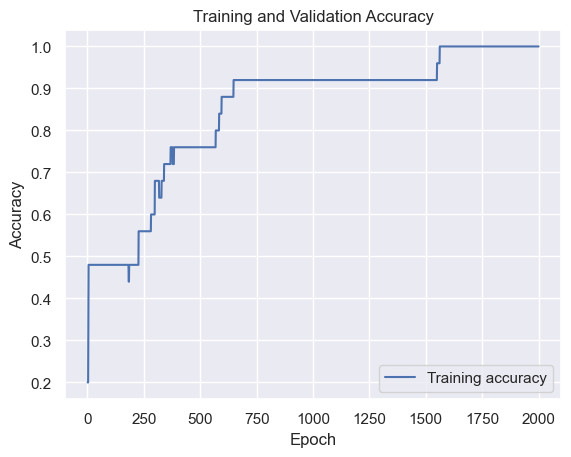

In [179]:
import seaborn  as sns

accuracy = np.array(accuracy)

accuracy = accuracy.T
sns.set()
 
epochs = range(1, len(accuracy[0]) + 1)
 
plt.plot(epochs, accuracy[0], '-', label='Training accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [181]:
y_pred = model.predict(X_train)


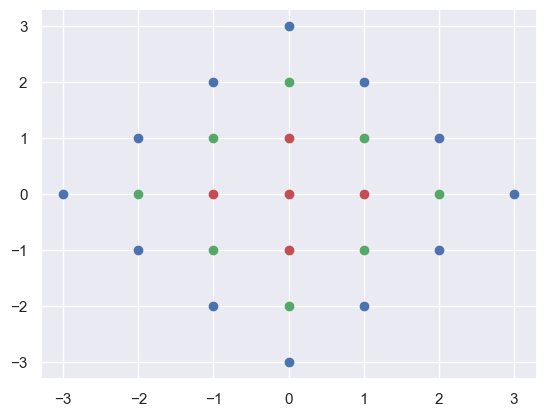

In [182]:

X = X_train

d = np.argmax(y_pred, axis=1)

plt.figure()

plt.plot(X[d==0,0],X[d==0,1], 'ro')
plt.plot(X[d==1,0],X[d==1,1], 'go')
plt.plot(X[d==2,0],X[d==2,1], 'bo')
plt.show()